# Proyecto Big Data – Ingesta TradingView (Stellar / XLM) y particionado en RAW

Este notebook muestra, de forma ordenada y reproducible:

1. Acceso a TradingView (vía librería `TradingviewData`).
2. Prueba rápida de descarga (daily) y verificación en pantalla.
3. Ingesta completa (daily) para 2022–2025.
4. Limpieza: eliminamos `symbol` antes de guardar (evitamos redundancia).
5. Almacenamiento en RAW con dos estrategias:
   - `yearly/` → un CSV por año.
   - `monthly/` → un CSV por mes dentro de cada año.


In [1]:
import os
import pandas as pd
from TradingviewData import TradingViewData, Interval
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
print(sys.executable)

C:\Users\maria\anaconda3\envs\pyenv\python.exe


## 1) Acceso a TradingView (cliente)

Creamos el cliente `TradingViewData()`. La librería gestiona internamente la conexión/consulta a TradingView.


In [3]:
request = TradingViewData()

## 2) Prueba rápida: descarga DAILY y evidencia en pantalla

Descargamos pocas filas (n_bars=10) para demostrar que el acceso funciona y ver el formato de los datos.


In [4]:
sample = request.get_hist(
    symbol="XLMUSD",
    exchange="BINANCE",
    interval=Interval.daily,
    n_bars=100
)

sample

,symbol,open,high,low,close,volume
datetime,,,,,,
2025-10-26 02:00:00,BINANCE:XLMUSD,0.324851,0.334658,0.322699,0.330872,1335592.0
2025-10-27 01:00:00,BINANCE:XLMUSD,0.331972,0.335591,0.321225,0.323085,1048621.0
2025-10-28 01:00:00,BINANCE:XLMUSD,0.321684,0.337110,0.314409,0.319613,2110536.0
2025-10-29 01:00:00,BINANCE:XLMUSD,0.318334,0.325029,0.310983,0.316100,2175770.0
2025-10-30 01:00:00,BINANCE:XLMUSD,0.315945,0.318643,0.289819,0.298238,2072368.0
...,...,...,...,...,...,...
2026-01-29 01:00:00,BINANCE:XLMUSD,0.209235,0.209363,0.194728,0.199679,2155231.0
2026-01-30 01:00:00,BINANCE:XLMUSD,0.198876,0.199311,0.189367,0.191835,3276766.0
2026-01-31 01:00:00,BINANCE:XLMUSD,0.191802,0.192468,0.165895,0.180908,3972294.0


## 2.5) Representación gráfica inicial (validación visual)

Antes de continuar con el almacenamiento y particionado, se realiza una
visualización simple del precio de cierre (`close`) para validar
visualmente que los datos descargados son coherentes.


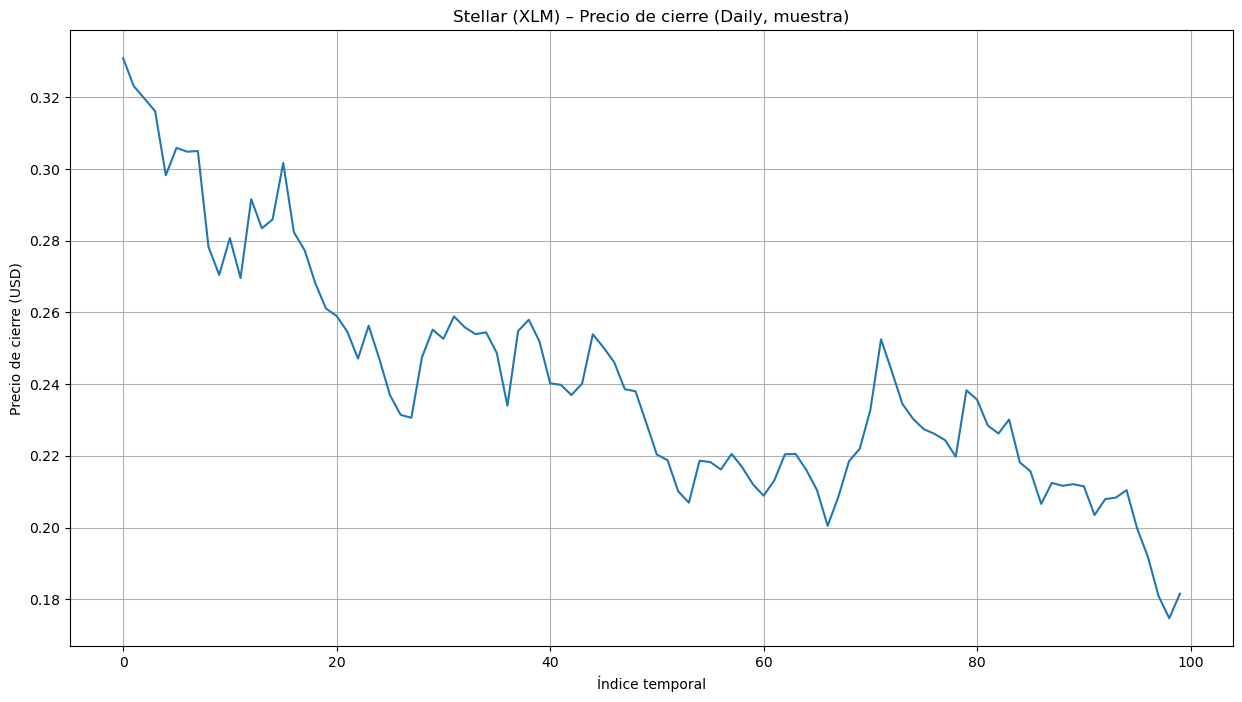

In [5]:
# Normalizar sample
sample_df = sample.reset_index()
sample_df["datetime"] = pd.to_datetime(sample_df["datetime"], utc=True)

# Gráfica del precio de cierre
sample_df["close"].plot(figsize=(15, 8))
plt.title("Stellar (XLM) – Precio de cierre (Daily, muestra)")
plt.xlabel("Índice temporal")
plt.ylabel("Precio de cierre (USD)")
plt.grid(True)
plt.show()

## 3) Ingesta completa DAILY (para llegar a 2022)

Usamos `n_bars` alto para cubrir aproximadamente desde 2022 hasta el presente.
Si el mínimo no llega a 2022, aumentar `n_bars` (por ejemplo 2000).


In [7]:
data = request.get_hist(
    symbol="XLMUSD",          # alternativa: "XLMUSDT"
    exchange="BINANCE",
    interval=Interval.daily,
    n_bars=1800
)

df = data.reset_index()
df["datetime"] = pd.to_datetime(df["datetime"])

print("Rango descargado:", df["datetime"].min(), "→", df["datetime"].max())
df.head()


Rango descargado: 2021-03-01 01:00:00 → 2026-02-02 01:00:00


,datetime,symbol,open,high,low,close,volume
0,2021-03-01 01:00:00,BINANCE:XLMUSD,0.406775,0.449486,0.377428,0.430864,6.659150e+07
1,2021-03-02 01:00:00,BINANCE:XLMUSD,0.431341,0.445252,0.394899,0.419542,4.863506e+07
2,2021-03-03 01:00:00,BINANCE:XLMUSD,0.418947,0.455544,0.395936,0.420699,4.578823e+07
3,2021-03-04 01:00:00,BINANCE:XLMUSD,0.420740,0.444530,0.390456,0.411999,4.975270e+07
4,2021-03-05 01:00:00,BINANCE:XLMUSD,0.411977,0.423097,0.379965,0.404660,3.264256e+07


## 4) Filtrado 2022–2025 y limpieza

- Filtramos los años 2022 a 2025.
- Eliminamos la columna `symbol` antes de guardar:
  - Es redundante (ya sabemos que el dataset es XLM por la ruta/nombre).
  - A escala Big Data, guardar campos redundantes incrementa almacenamiento y coste de procesamiento.


In [8]:
df = df[df["datetime"].dt.year.between(2022, 2025)].copy()

if "symbol" in df.columns:
    df = df.drop(columns=["symbol"])

years_available = sorted(df["datetime"].dt.year.unique())
print("Años disponibles:", years_available)

df.head()


Años disponibles: [2022, 2023, 2024, 2025]


,datetime,open,high,low,close,volume
306,2022-01-01 01:00:00,0.266864,0.280046,0.263113,0.276927,1.489520e+07
307,2022-01-02 01:00:00,0.277060,0.297308,0.270683,0.292460,2.047819e+07
308,2022-01-03 01:00:00,0.292158,0.301638,0.279243,0.289828,2.658327e+07
309,2022-01-04 01:00:00,0.290102,0.297851,0.275504,0.279617,1.526306e+07
310,2022-01-05 01:00:00,0.279471,0.299475,0.254579,0.266800,3.522648e+07


## 5) Particionado en RAW (yearly y monthly)

Creamos dos estructuras en `data/raw/stellar/`:

- `yearly/`: un CSV por año (útil para análisis por año completo).
- `monthly/`: un CSV por mes dentro de cada año (útil para procesos incrementales y consultas más selectivas).

Estructura resultante:
- `data/raw/stellar/yearly/year=YYYY/XLM_YYYY.csv`
- `data/raw/stellar/monthly/year=YYYY/month=MM/XLM_YYYY_MM.csv`


In [9]:
import os

# Raíz según lo que quieres
base_dir = "data/raw/XLM"

# =========================
# 5.1) YEARLY
# =========================
for year in years_available:
    year_folder = os.path.join(base_dir, "yearly", f"year={year}")
    os.makedirs(year_folder, exist_ok=True)

    df_year = df[df["datetime"].dt.year == year].copy()
    out_path = os.path.join(year_folder, f"XLM_{year}.csv")
    df_year.to_csv(out_path, index=False)

    print(f"yearly -> {out_path} | filas: {len(df_year)}")


# =========================
# 5.2) MONTHLY
# =========================
for year in years_available:
    year_folder = os.path.join(base_dir, "monthly", f"year={year}")
    os.makedirs(year_folder, exist_ok=True)

    months_available = sorted(
        df[df["datetime"].dt.year == year]["datetime"].dt.month.unique()
    )

    for month in months_available:
        mm = f"{month:02d}"
        month_folder = os.path.join(year_folder, f"month={mm}")
        os.makedirs(month_folder, exist_ok=True)

        df_month = df[
            (df["datetime"].dt.year == year) &
            (df["datetime"].dt.month == month)
        ].copy()

        out_path = os.path.join(month_folder, f"XLM_{year}_{mm}.csv")
        df_month.to_csv(out_path, index=False)

        print(f"monthly -> {out_path} | filas: {len(df_month)}")

print("Estructura creada en:", os.path.abspath(base_dir))


yearly -> data/raw/XLM\yearly\year=2022\XLM_2022.csv | filas: 365
yearly -> data/raw/XLM\yearly\year=2023\XLM_2023.csv | filas: 365
yearly -> data/raw/XLM\yearly\year=2024\XLM_2024.csv | filas: 366
yearly -> data/raw/XLM\yearly\year=2025\XLM_2025.csv | filas: 365
monthly -> data/raw/XLM\monthly\year=2022\month=01\XLM_2022_01.csv | filas: 31
monthly -> data/raw/XLM\monthly\year=2022\month=02\XLM_2022_02.csv | filas: 28
monthly -> data/raw/XLM\monthly\year=2022\month=03\XLM_2022_03.csv | filas: 31
monthly -> data/raw/XLM\monthly\year=2022\month=04\XLM_2022_04.csv | filas: 30
monthly -> data/raw/XLM\monthly\year=2022\month=05\XLM_2022_05.csv | filas: 31
monthly -> data/raw/XLM\monthly\year=2022\month=06\XLM_2022_06.csv | filas: 30
monthly -> data/raw/XLM\monthly\year=2022\month=07\XLM_2022_07.csv | filas: 31
monthly -> data/raw/XLM\monthly\year=2022\month=08\XLM_2022_08.csv | filas: 31
monthly -> data/raw/XLM\monthly\year=2022\month=09\XLM_2022_09.csv | filas: 30
monthly -> data/raw/XLM\m

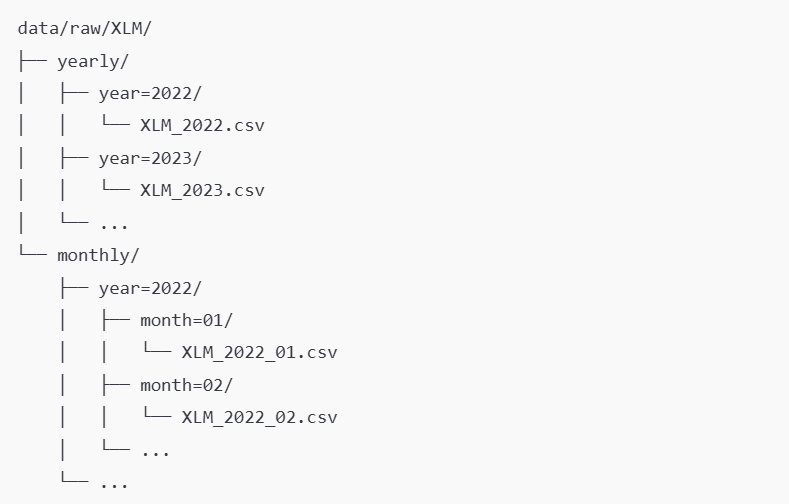


## 6) Justificación de decisiones

- **Acceso a datos**: se emplea TradingView mediante la librería `TradingviewData` para obtener histórico de mercado.
- **Particionado**:
  - `yearly/` permite análisis agregados por año y cargas sencillas.
  - `monthly/` permite cargas incrementales (por mes) y reduce lectura en consultas acotadas.
- **Eliminación de `symbol`**:
  - es información redundante (ya implícita por dataset/ruta),
  - a escala Big Data aumenta tamaño, I/O y coste de computación,
  - por eso se elimina antes de persistir los datos.
